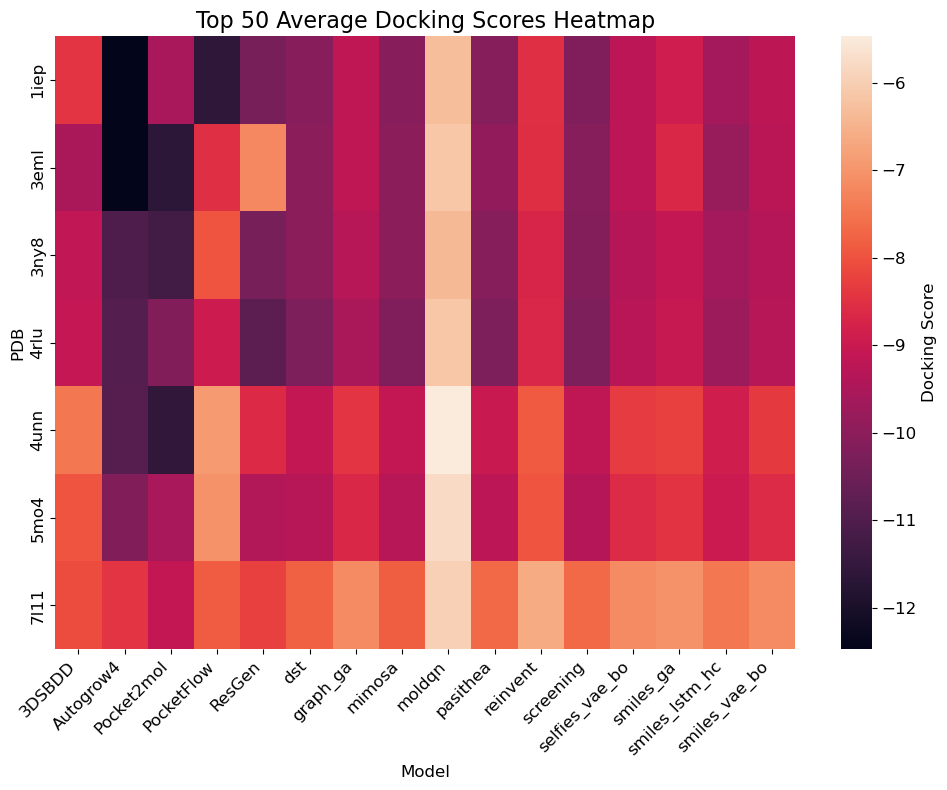

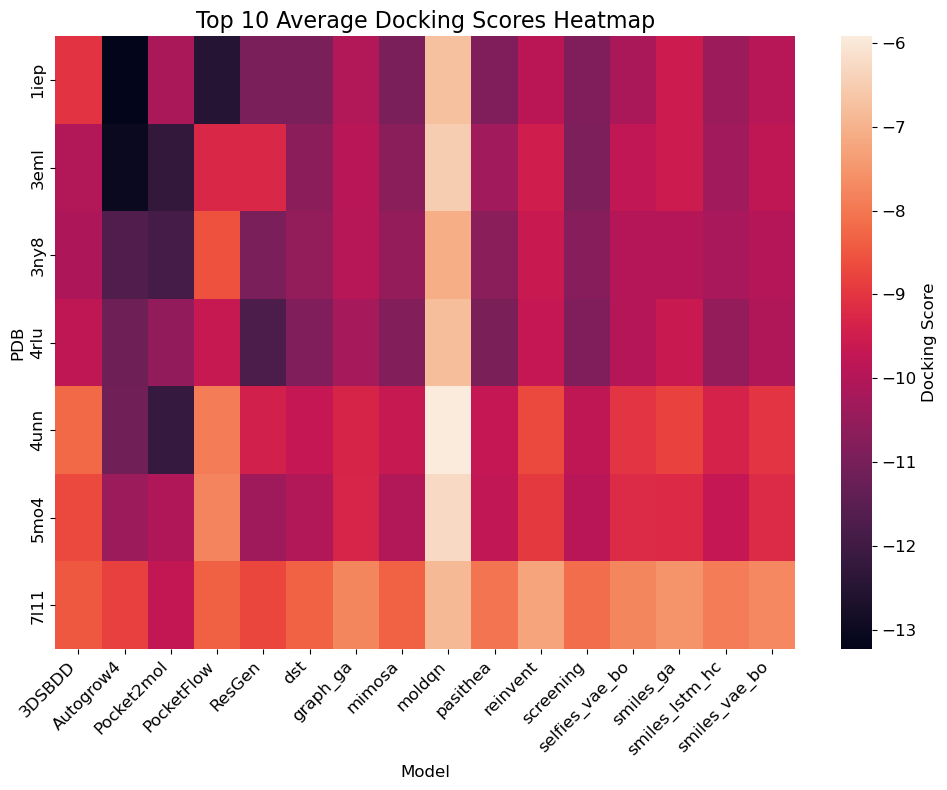

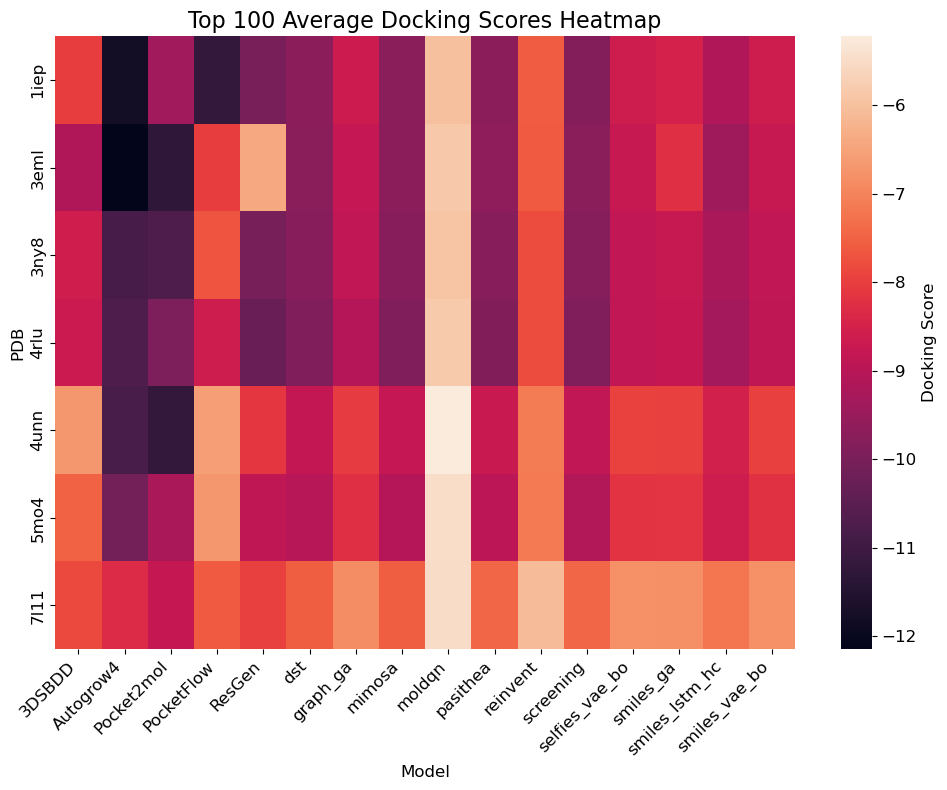

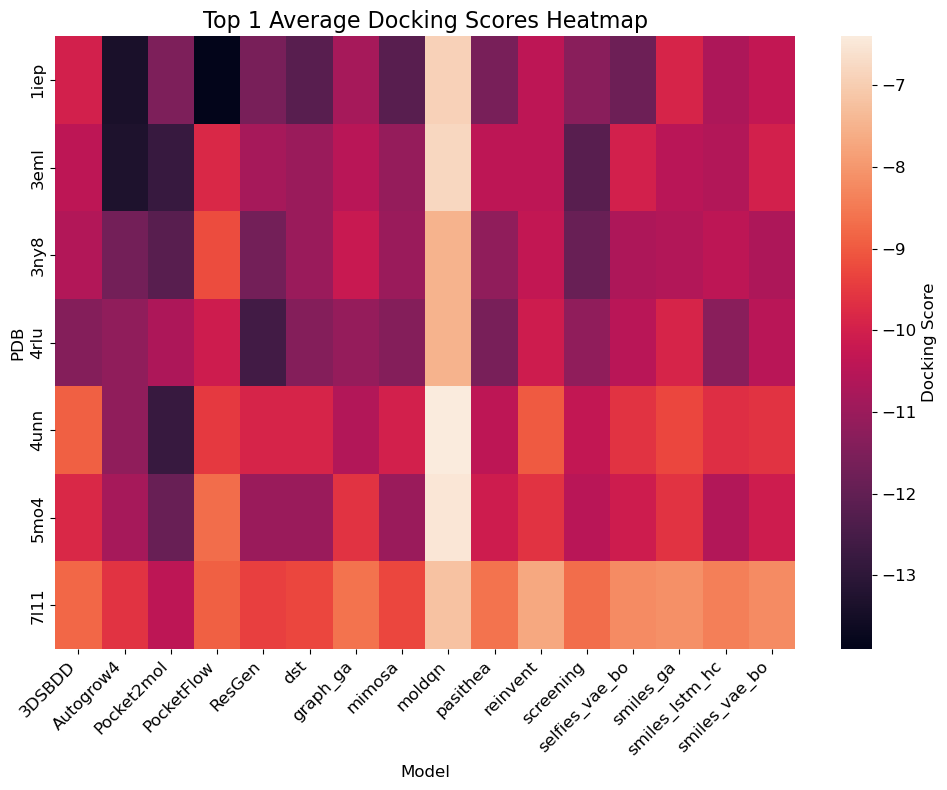

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import re
import csv
import os
import pandas as pd

# This section is used to create heatmap for Top n score

def process_files(pdb_code, folder_path, file_type):
    all_data = pd.DataFrame()
    models = []
    pattern = re.compile(rf'{re.escape(pdb_code)}_' + re.escape(file_type) + r'_(.+)\.csv')

    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            model = pattern.match(filename).group(1)
            full_path = os.path.join(folder_path, filename)
            df = pd.read_csv(full_path)
            df['model'] = model
            #df['pdb'] = pdb_code
            all_data = pd.concat([all_data, df])
            if model not in models:
                models.append(model)
    return all_data, models



pdb_list = ['1iep', '3eml', '3ny8', '4rlu', '4unn', '5mo4', '7l11']
#pdb_list = ['1iep']
eval_folder_path = '../eval_output_0222'
file_type = 'docking'

def create_top_n_avg_scores(eval_folder_path, top_n, pdb_list, file_type):
    all_data_list = []
    for pdb in pdb_list:
        all_data, models = process_files(pdb, eval_folder_path, file_type)



        top_n_avg_scores = all_data.groupby('model')['Docking score'].apply(lambda x: x.nsmallest(top_n).mean())
        top_n_avg_scores_df = top_n_avg_scores.reset_index()
        top_n_avg_scores_df.columns = ['Model', f'Top {top_n} Average Docking Score']
        top_n_avg_scores_df['pdb'] = pdb
        all_data_list.append(top_n_avg_scores_df)
    concatenated_df = pd.concat(all_data_list)
    #print(concatenated_df)
    heatmap_data = concatenated_df.pivot(index='pdb', columns='Model', values=f'Top {top_n} Average Docking Score')
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax = sns.heatmap(heatmap_data, linecolor="black", cbar_kws={'label': 'Docking Score'})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.yaxis.label.set_size(12)
    plt.title(f'Top {top_n} Average Docking Scores Heatmap', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('PDB', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f'top_{top_n}_avg_docking_scores_heatmap.pdf')

create_top_n_avg_scores(eval_folder_path, 50, pdb_list, 'docking')
create_top_n_avg_scores(eval_folder_path, 10, pdb_list, 'docking')
create_top_n_avg_scores(eval_folder_path, 100, pdb_list, 'docking')
create_top_n_avg_scores(eval_folder_path, 1, pdb_list, 'docking')

In [13]:
def create_top_n_ranking_table(df_list):
    df_result = pd.DataFrame()
    
    for df, top_n in df_list:
        # Group by model and calculate the average docking score for each model
        df_avg = df.groupby('Model')[f'Top {top_n} Average Docking Score'].mean()
        
        # Calculate the rank for each model based on the average docking score
        df_result[f'Top {top_n} Rank'] = df_avg.rank(ascending=True, method='min').astype(int)
    
    # Calculate the overall rank based on the average of the top-n ranks for each model
    df_result['Overall Rank'] = df_result.mean(axis=1).rank(ascending=True, method='min').astype(int)
    #df_result['Overall Rank'] = df_result['Overall Rank'].apply(lambda x: f"{x:.2f}")
    # Convert the DataFrame to a LaTeX table string
    latex_table = df_result.to_latex(escape=False, index=True, column_format='lrrr')
    
    # Customize the table layout
    latex_table = latex_table.replace('\\toprule', '\\hline')
    latex_table = latex_table.replace('\\midrule', '\\hline')
    latex_table = latex_table.replace('\\bottomrule', '\\hline')
    
    # Add bold formatting to the header row
    header_row = latex_table.split('\n')[2]
    header_row = '\\textbf{' + header_row.replace('&', '} & \\textbf{') + '}'
    latex_table = latex_table.replace(latex_table.split('\n')[2], header_row)
    
    # Add caption and label to the table
    caption = "Model Rankings based on Top-n Average Docking Scores"
    label = "tab:model_rankings_top_n"
    latex_table = latex_table.replace('\\end{tabular}', '\\caption{' + caption + '}\n\\label{' + label + '}\n\\end{tabular}')
    
    return latex_table


df_list = [(pd.read_csv("../rank_latex_table/ranked_results_1_docking.csv"), 1),
           (pd.read_csv("../rank_latex_table/ranked_results_10_docking.csv"), 10),
           (pd.read_csv("../rank_latex_table/ranked_results_100_docking.csv"), 100)]
latex_table_top_n_rankings = create_top_n_ranking_table(df_list)
save_table_to_file(latex_table_top_n_rankings, "../rank_latex_table/average_docking.txt")


/tmp/slurmtmp.28105853/ipykernel_263951/1688507861.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_result.to_latex(escape=False, index=True, column_format='lrrr')


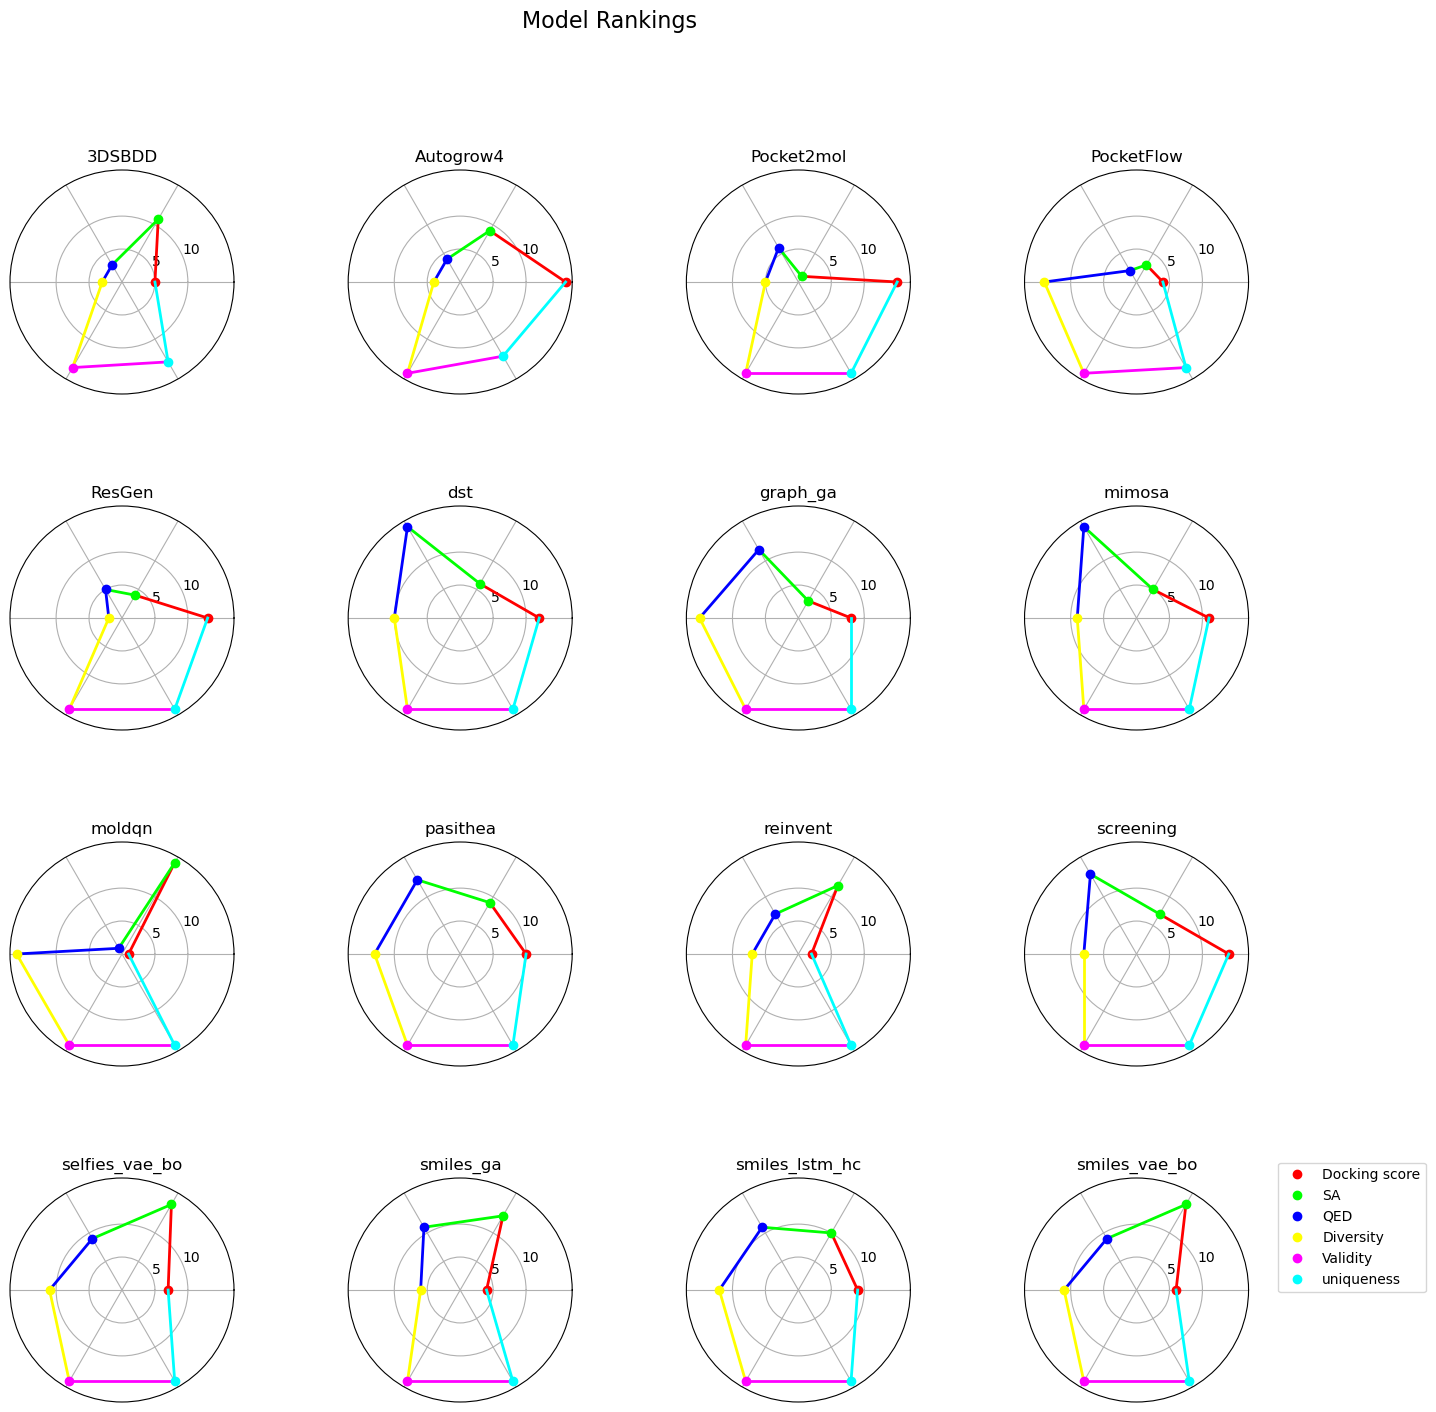

In [19]:
import numpy as np
import matplotlib.pyplot as plt


# This section is used to create radar chart


# Define the models and their rankings
models = ['3DSBDD', 'Autogrow4', 'Pocket2mol', 'PocketFlow', 'ResGen', 'dst', 'graph_ga', 'mimosa',
          'moldqn', 'pasithea', 'reinvent', 'screening', 'selfies_vae_bo', 'smiles_ga', 'smiles_lstm_hc', 'smiles_vae_bo']
rankings = {
    '3DSBDD': [12, 6, 14, 14, 2, 3],
    'Autogrow4': [1, 8, 13, 13, 1, 4],
    'Pocket2mol': [2, 16, 11, 12, 1, 1],
    'PocketFlow': [13, 14, 15, 3, 1, 2],
    'ResGen': [4, 13, 12, 15, 1, 1],
    'dst': [5, 11, 1, 7, 1, 1],
    'graph_ga': [9, 14, 5,2,1,1],
    'mimosa': [6, 12, 1,8,1,1],
    'moldqn': [16, 1, 16,1,1,1],
    'pasithea': [7, 8, 4,4,1,1],
    'reinvent': [15, 5, 10,10,1,1],
    'screening': [3, 10, 3,9,1,1],
    'selfies_vae_bo': [10, 2, 8,6,1,1],
    'smiles_ga': [13, 4, 6,11,1,1],
    'smiles_lstm_hc': [8, 7, 6,5,1,1],
    'smiles_vae_bo': [11, 2, 8,6,1,1]
}

# Define the ranking labels
ranking_labels = ['Docking score', 'SA', 'QED', 'Diversity', 'Validity', 'uniqueness']
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF']
# Calculate the angles for each ranking label
angles = np.linspace(0, 2*np.pi, len(ranking_labels), endpoint=False)

# Create the figure and subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16), subplot_kw=dict(polar=True))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Model Rankings radar chart', fontsize=16)

# Iterate over each model and plot its radar chart
for i, model in enumerate(models):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Get the rankings for the current model
    values = rankings[model]
    values = [17 - val for val in values]
    # Close the plot by appending the first value to the end
    values = np.append(values, values[0])
    angles_plot = np.append(angles, angles[0])

    for j in range(len(ranking_labels)):
        ax.plot(angles_plot[j:j+2], values[j:j+2], '-', linewidth=2, color=colors[j])
        ax.plot(angles_plot[j], values[j], 'o', color=colors[j], label=ranking_labels[j])

    # Set the labels and title
    ax.set_thetagrids(angles * 180/np.pi, [])
    ax.set_title(model)

    # Set the radial limits and remove the grid lines
    ax.set_rlim(0, 17)
    ax.set_rticks([5, 10])
    ax.grid(True)

# Add a legend to the last subplot
axes[-1, -1].legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))

# Save the figure
plt.savefig('radar_charts.pdf', dpi=300, bbox_inches='tight')

plt.show()

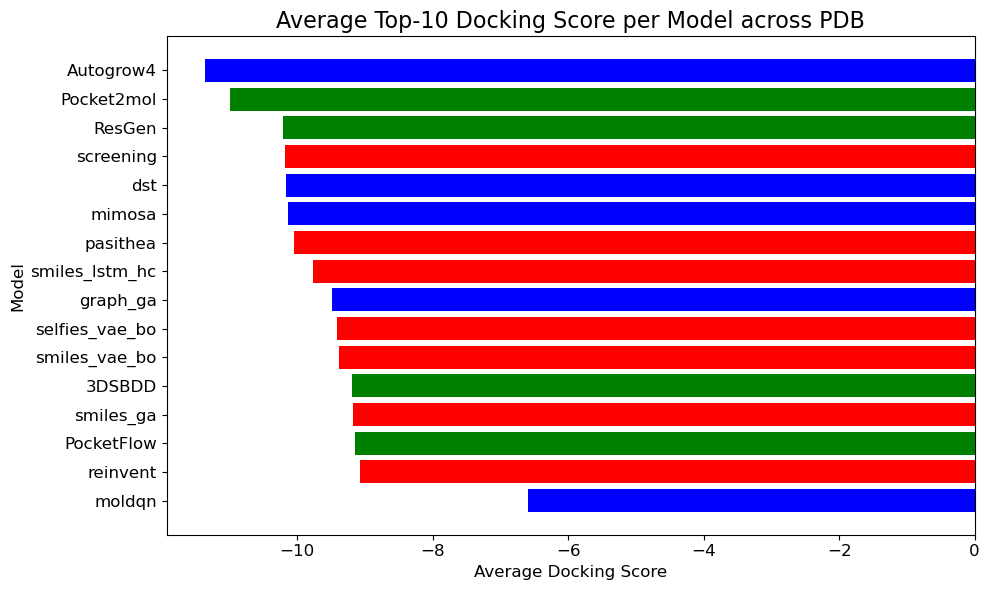

In [18]:
import pandas as pd
import matplotlib.pyplot as plt


# This section is used to create bar chart


# Read the CSV file
df = pd.read_csv('../rank_latex_table/ranked_results_10_docking.csv')

# Calculate the average docking score for each model
model_avg_scores = df.groupby('Model')['Top 10 Average Docking Score'].mean().sort_values()
model_type_colors = {
    'Autogrow4': 'blue',
    'Pocket2mol': 'green',
    'ResGen': 'green',
    'screening': 'red',
    'dst': 'blue',
    'mimosa': 'blue',
    'pasithea': 'red',
    'smiles_lstm_hc': 'red', 
    'graph_ga': 'blue', 
    'selfies_vae_bo': 'red', 
    'smiles_vae_bo': 'red',
    '3DSBDD': 'green', 
    'smiles_ga': 'red', 
    'PocketFlow': 'green', 
    'reinvent': 'red', 
    'moldqn': 'blue'
}

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = [model_type_colors[t] for t in list(model_avg_scores.index)]
ax.barh(model_avg_scores.index, model_avg_scores.values, color=colors)

# Set the chart title and labels
ax.set_title('Average Top-10 Docking Score per Model across PDB', fontsize=16)
ax.set_xlabel('Average Docking Score', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
# Invert the y-axis to show the ranking from top to bottom
ax.invert_yaxis()

# Display the chart
plt.tight_layout()
plt.savefig('average_10_docking_score_bar.pdf')
plt.show()